In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, roc_curve, auc, precision_score, recall_score)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess_input


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split


import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau



import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, callbacks

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

2024-12-23 02:46:38.735439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 02:46:39.278994: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 02:46:40.629441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/abdo/miniconda3/envs/tf/lib/
2024-12-23 02:46:40.630282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-12-23 02:46:47.841035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-23 02:46:47.892660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-23 02:46:47.892771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [8]:
# Common settings
base_dir = '../Data/raw/5'
img_height, img_width = 150, 150
batch_size = 32

def random_contrast(image):
    contrast_factor = tf.random.uniform([], 0.5, 1.5)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.2,  # Increased to 0.2 for a clearer split
    preprocessing_function=random_contrast
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use the same split as train_datagen
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Specify 'validation' subset
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


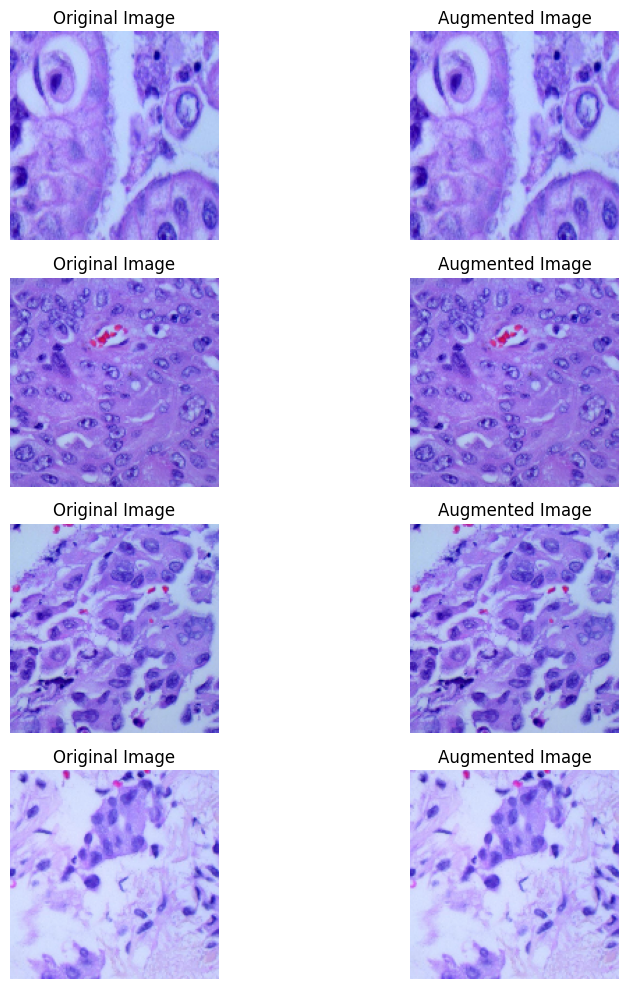

In [9]:
def display_images(generator, num_images=4):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 10))
    axs = axs.flatten()

    for i in range(num_images):
        img, label = next(generator)
        axs[2*i].imshow(img[0])
        axs[2*i].set_title('Original Image')
        axs[2*i].axis('off')

        axs[2*i+1].imshow(img[0])
        axs[2*i+1].set_title('Augmented Image')
        axs[2*i+1].axis('off')

    plt.tight_layout()
    plt.show()

# Display original and augmented images for validation data
display_images(validation_generator)

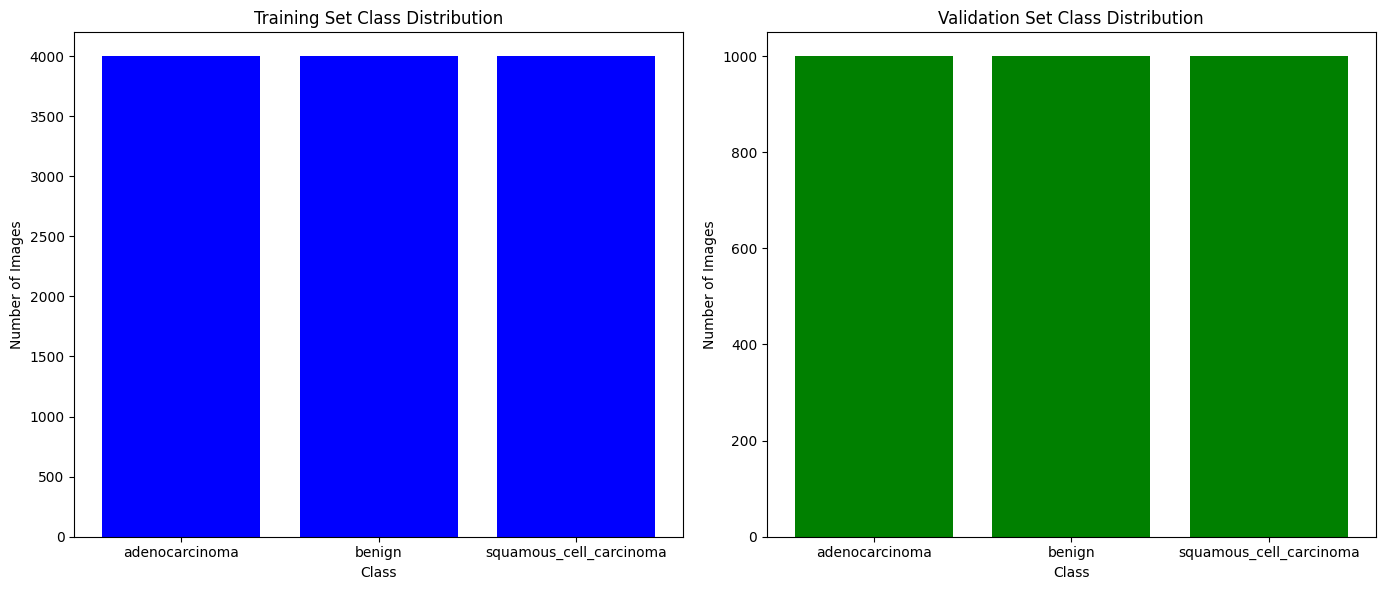

In [10]:
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Get the class labels
class_labels = list(train_class_indices.keys())

# Count the number of images per class in training and validation sets
train_counts = np.zeros(len(class_labels))
validation_counts = np.zeros(len(class_labels))

for i, label in enumerate(train_generator.classes):
    train_counts[label] += 1

for i, label in enumerate(validation_generator.classes):
    validation_counts[label] += 1

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

ax[1].bar(class_labels, validation_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

In [11]:
# Function to get image shapes
def get_image_shapes(generator):
    shapes = []
    for i in range(len(generator)):
        images, _ = generator[i]
        for img in images:
            shapes.append(img.shape)
    return np.array(shapes)

# Get shapes for training and validation sets
train_shapes = get_image_shapes(train_generator)
validation_shapes = get_image_shapes(validation_generator)

# Calculate statistics
def calculate_statistics(shapes):
    unique_shapes = np.unique(shapes, axis=0)
    min_dimensions = np.min(shapes, axis=0)
    max_dimensions = np.max(shapes, axis=0)
    mean_dimensions = np.mean(shapes, axis=0)
    return unique_shapes, min_dimensions, max_dimensions, mean_dimensions

train_unique_shapes, train_min_dimensions, train_max_dimensions, train_mean_dimensions = calculate_statistics(train_shapes)
validation_unique_shapes, validation_min_dimensions, validation_max_dimensions, validation_mean_dimensions = calculate_statistics(validation_shapes)

# Print statistics
print("Training Dataset:")
print(f"Number of images: {len(train_shapes)}")
print(f"Unique shapes: {train_unique_shapes}")
print(f"Min dimensions: {train_min_dimensions}")
print(f"Max dimensions: {train_max_dimensions}")
print(f"Mean dimensions: {train_mean_dimensions}")

print("\nValidation Dataset:")
print(f"Number of images: {len(validation_shapes)}")
print(f"Unique shapes: {validation_unique_shapes}")
print(f"Min dimensions: {validation_min_dimensions}")
print(f"Max dimensions: {validation_max_dimensions}")
print(f"Mean dimensions: {validation_mean_dimensions}")

Training Dataset:
Number of images: 12000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]

Validation Dataset:
Number of images: 3000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]


In [69]:
# Load the ResNet50 model, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [70]:
# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

In [71]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, check_point, reduce_lr]
)

Epoch 1/10
375/375 [==============================] - 528s 1s/step - loss: 0.1270 - accuracy: 0.9513 - val_loss: 6.9222 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/10
375/375 [==============================] - 515s 1s/step - loss: 0.0407 - accuracy: 0.9868 - val_loss: 1.2467 - val_accuracy: 0.6037 - lr: 1.0000e-04
Epoch 3/10
375/375 [==============================] - 543s 1s/step - loss: 0.0271 - accuracy: 0.9918 - val_loss: 0.0941 - val_accuracy: 0.9850 - lr: 1.0000e-04
Epoch 4/10
375/375 [==============================] - 705s 2s/step - loss: 0.0163 - accuracy: 0.9942 - val_loss: 0.0362 - val_accuracy: 0.9923 - lr: 1.0000e-04
Epoch 5/10
375/375 [==============================] - 517s 1s/step - loss: 0.0146 - accuracy: 0.9954 - val_loss: 0.0183 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 6/10
375/375 [==============================] - 178s 475ms/step - loss: 0.0204 - accuracy: 0.9943 - val_loss: 0.4861 - val_accuracy: 0.9023 - lr: 1.0000e-04
Epoch 7/10
375/375 [=================

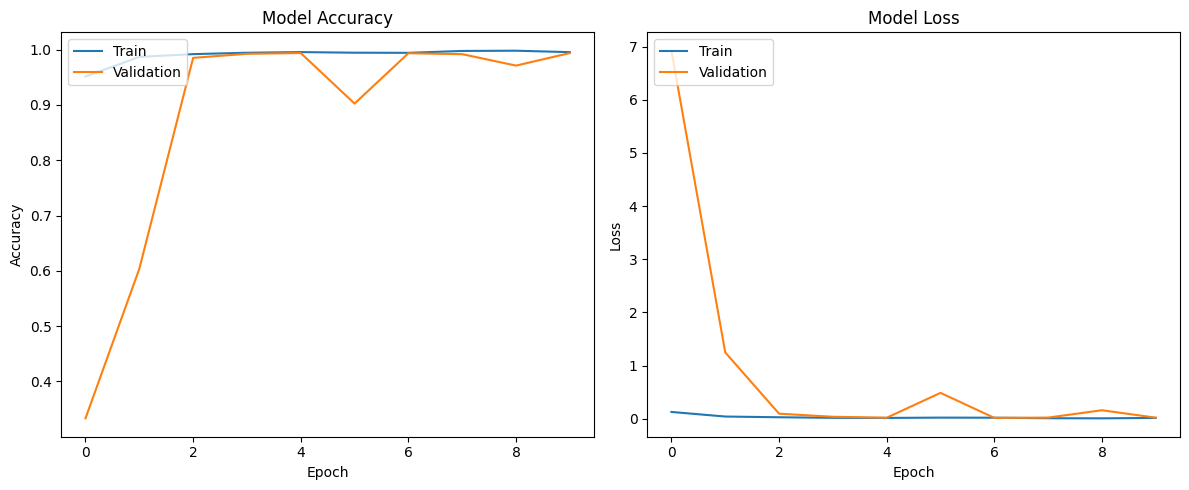

In [72]:
# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

Evaluating the model on the validation set...
94/94 [==============================] - 24s 249ms/step - loss: 0.0154 - accuracy: 0.9933
Validation Accuracy: 99.33%
Weighted F1 Score: 0.9933
Weighted Precision: 0.9935
Weighted Recall: 0.9933
Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       1.00      0.98      0.99      1000
                 benign       1.00      1.00      1.00      1000
squamous_cell_carcinoma       0.98      1.00      0.99      1000

               accuracy                           0.99      3000
              macro avg       0.99      0.99      0.99      3000
           weighted avg       0.99      0.99      0.99      3000



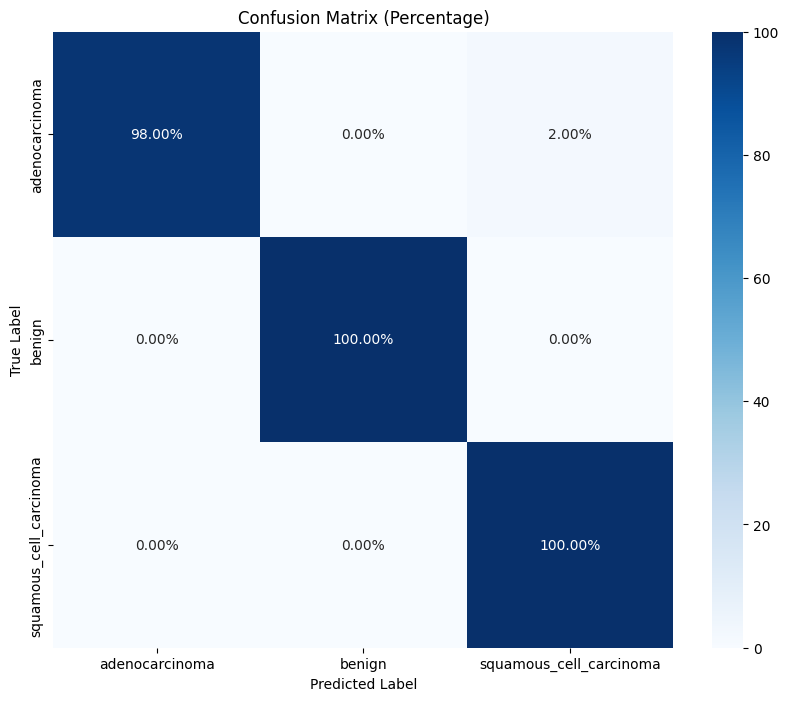

In [73]:


MODEL_NAME = "lung_cancer-resnet50"
OUTPUT_CONFUSION_MATRICES_DIR = os.path.join('../output/confusion_matrices/', MODEL_NAME)
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
OUTPUT_EVALUATION_METRICS_DIR = os.path.join('../output/evaluation_metrics/', MODEL_NAME)
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)


# Evaluate the model on the validation data
print("Evaluating the model on the validation set...")
validation_generator.reset()  # Reset the generator to ensure predictions are correct
Y_pred_prob = model.predict(validation_generator, verbose=1)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Calculate metrics
evaluation_accuracy = model.evaluate(validation_generator, verbose=1)[1]
f1 = f1_score(Y_true, Y_pred, average='weighted')
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Confusion matrix with percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percentage = np.nan_to_num(cm_percentage)

# Prepare annotations with percentage symbol
annot_labels = np.empty_like(cm_percentage).astype(str)
nrows, ncols = cm_percentage.shape
for i in range(nrows):
    for j in range(ncols):
        annot_labels[i, j] = f'{cm_percentage[i, j]:.2f}%'

plt.figure(figsize=(10,8))
sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Save confusion matrix
OUTPUT_CONFUSION_MATRICES_DIR = '../output/confusion_matrices/' + MODEL_NAME
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'confusion_matrix_percentage.png')
plt.savefig(confusion_matrix_path)
plt.show()

# Save evaluation metrics to CSV
import pandas as pd
metrics_data = {
    'Metric': ['Validation Accuracy', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall'],
    'Value': [evaluation_accuracy, f1, precision, recall]
}
metrics_df = pd.DataFrame(metrics_data)
OUTPUT_EVALUATION_METRICS_DIR = '../output/evaluation_metrics/' + MODEL_NAME
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)
metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)

# Save the final model
MODEL_DIR = '../models/' + MODEL_NAME
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, 'model_final.h5'))

In [74]:
# Common settings
base_dir = '../Data/raw/5'
img_height, img_width = 150, 150
batch_size = 32

def random_contrast(image):
    contrast_factor = tf.random.uniform([], 0.5, 1.5)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,  # Increased to 0.2 for a clearer split
    preprocessing_function=random_contrast
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use the same split as train_datagen
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Specify 'validation' subset
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


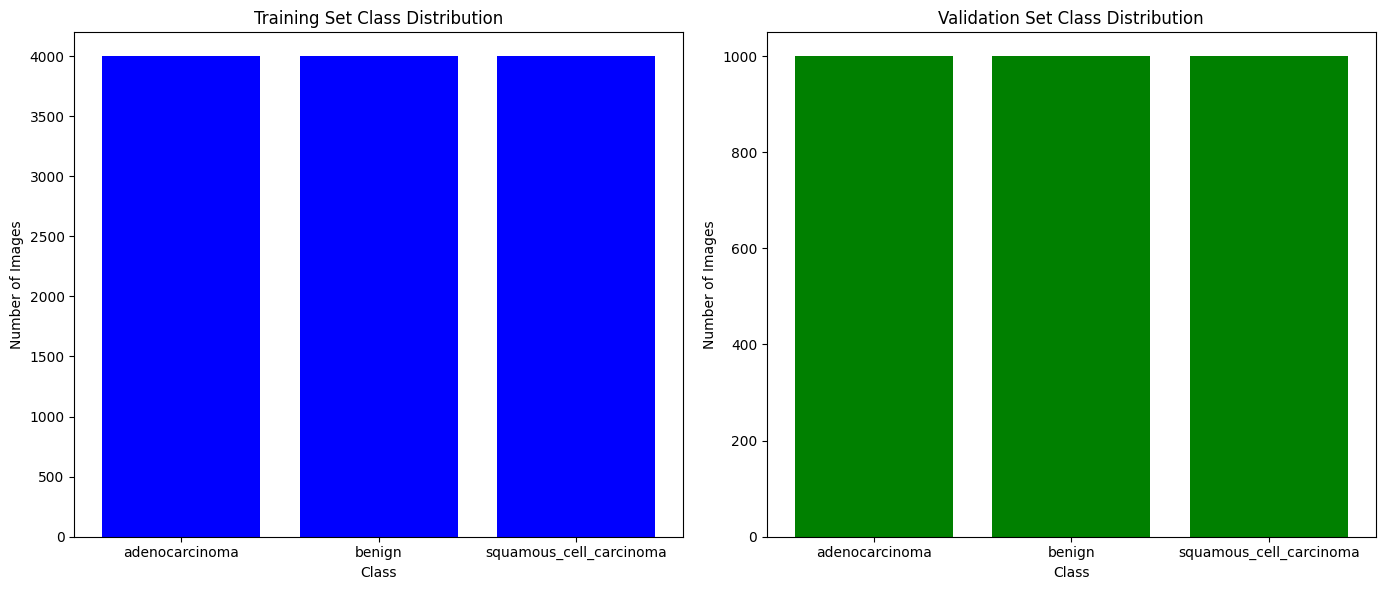

Training Dataset:
Number of images: 12000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]

Validation Dataset:
Number of images: 3000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_13[0][0]']               
                                                    

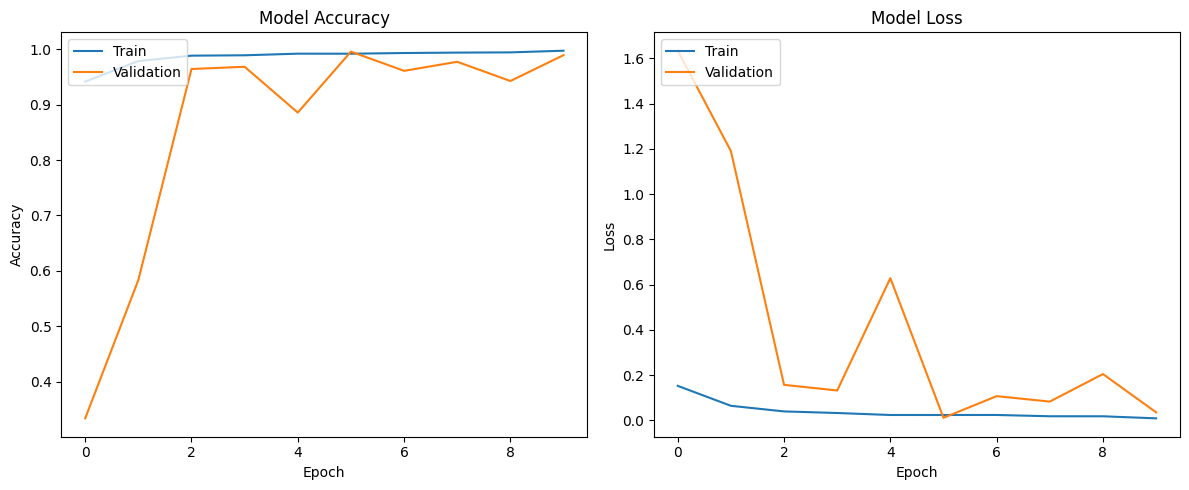

Evaluating the model on the validation set...
94/94 [==============================] - 23s 241ms/step - loss: 0.0353 - accuracy: 0.9893
Validation Accuracy: 98.93%
Weighted F1 Score: 0.9893
Weighted Precision: 0.9897
Weighted Recall: 0.9893
Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       1.00      0.97      0.98      1000
                 benign       1.00      1.00      1.00      1000
squamous_cell_carcinoma       0.97      1.00      0.98      1000

               accuracy                           0.99      3000
              macro avg       0.99      0.99      0.99      3000
           weighted avg       0.99      0.99      0.99      3000



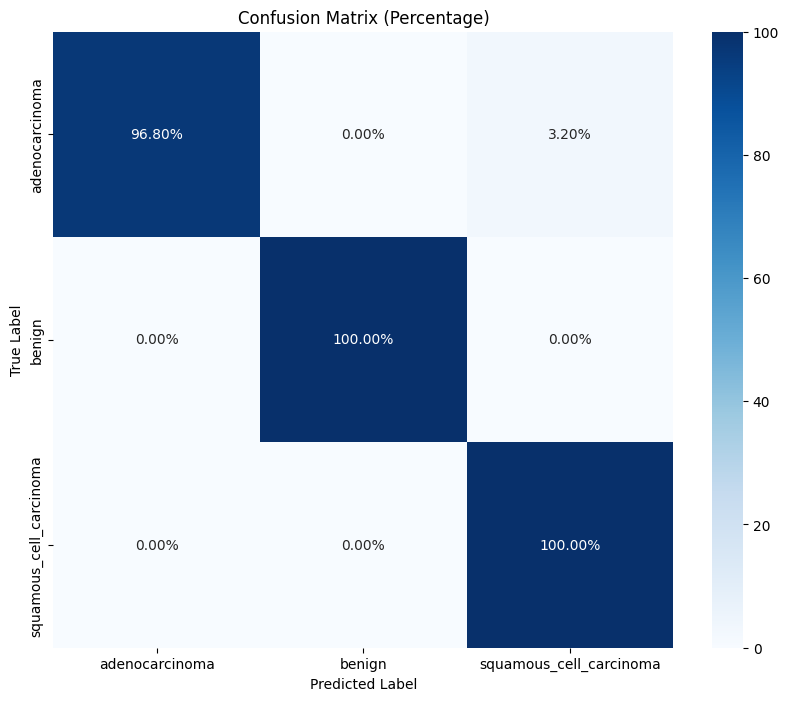

In [75]:
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Get the class labels
class_labels = list(train_class_indices.keys())

# Count the number of images per class in training and validation sets
train_counts = np.zeros(len(class_labels))
validation_counts = np.zeros(len(class_labels))

for i, label in enumerate(train_generator.classes):
    train_counts[label] += 1

for i, label in enumerate(validation_generator.classes):
    validation_counts[label] += 1

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

ax[1].bar(class_labels, validation_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

# Function to get image shapes
def get_image_shapes(generator):
    shapes = []
    for i in range(len(generator)):
        images, _ = generator[i]
        for img in images:
            shapes.append(img.shape)
    return np.array(shapes)

# Get shapes for training and validation sets
train_shapes = get_image_shapes(train_generator)
validation_shapes = get_image_shapes(validation_generator)

# Calculate statistics
def calculate_statistics(shapes):
    unique_shapes = np.unique(shapes, axis=0)
    min_dimensions = np.min(shapes, axis=0)
    max_dimensions = np.max(shapes, axis=0)
    mean_dimensions = np.mean(shapes, axis=0)
    return unique_shapes, min_dimensions, max_dimensions, mean_dimensions

train_unique_shapes, train_min_dimensions, train_max_dimensions, train_mean_dimensions = calculate_statistics(train_shapes)
validation_unique_shapes, validation_min_dimensions, validation_max_dimensions, validation_mean_dimensions = calculate_statistics(validation_shapes)

# Print statistics
print("Training Dataset:")
print(f"Number of images: {len(train_shapes)}")
print(f"Unique shapes: {train_unique_shapes}")
print(f"Min dimensions: {train_min_dimensions}")
print(f"Max dimensions: {train_max_dimensions}")
print(f"Mean dimensions: {train_mean_dimensions}")

print("\nValidation Dataset:")
print(f"Number of images: {len(validation_shapes)}")
print(f"Unique shapes: {validation_unique_shapes}")
print(f"Min dimensions: {validation_min_dimensions}")
print(f"Max dimensions: {validation_max_dimensions}")
print(f"Mean dimensions: {validation_mean_dimensions}")


# Load the ResNet50 model, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.summary()



# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)


# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)



# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, check_point, reduce_lr]
)


# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


MODEL_NAME = "lung_cancer-resnet50-augmneted"
OUTPUT_CONFUSION_MATRICES_DIR = os.path.join('../output/confusion_matrices/', MODEL_NAME)
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
OUTPUT_EVALUATION_METRICS_DIR = os.path.join('../output/evaluation_metrics/', MODEL_NAME)
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)


# Evaluate the model on the validation data
print("Evaluating the model on the validation set...")
validation_generator.reset()  # Reset the generator to ensure predictions are correct
Y_pred_prob = model.predict(validation_generator, verbose=1)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Calculate metrics
evaluation_accuracy = model.evaluate(validation_generator, verbose=1)[1]
f1 = f1_score(Y_true, Y_pred, average='weighted')
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Confusion matrix with percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percentage = np.nan_to_num(cm_percentage)

# Prepare annotations with percentage symbol
annot_labels = np.empty_like(cm_percentage).astype(str)
nrows, ncols = cm_percentage.shape
for i in range(nrows):
    for j in range(ncols):
        annot_labels[i, j] = f'{cm_percentage[i, j]:.2f}%'

plt.figure(figsize=(10,8))
sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Save confusion matrix
OUTPUT_CONFUSION_MATRICES_DIR = '../output/confusion_matrices/' + MODEL_NAME
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'confusion_matrix_percentage.png')
plt.savefig(confusion_matrix_path)
plt.show()

# Save evaluation metrics to CSV
import pandas as pd
metrics_data = {
    'Metric': ['Validation Accuracy', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall'],
    'Value': [evaluation_accuracy, f1, precision, recall]
}
metrics_df = pd.DataFrame(metrics_data)
OUTPUT_EVALUATION_METRICS_DIR = '../output/evaluation_metrics/' + MODEL_NAME
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)
metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)

# Save the final model
MODEL_DIR = '../models/' + MODEL_NAME
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, 'model_final.h5'))

In [28]:
# Common settings
base_dir = '../Data/raw/5'
img_height, img_width = 150, 150
batch_size = 32

def random_contrast(image):
    contrast_factor = tf.random.uniform([], 0.5, 1.5)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.2,  # Increased to 0.2 for a clearer split
    preprocessing_function=random_contrast
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use the same split as train_datagen
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Specify 'validation' subset
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


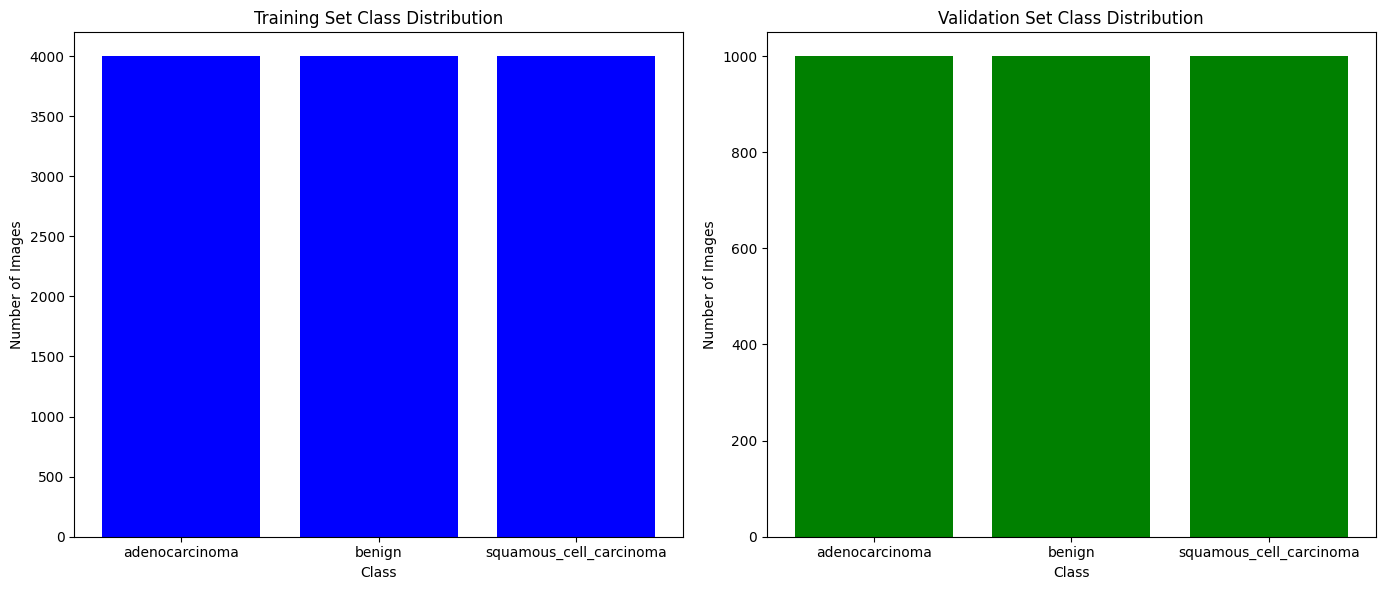

Training Dataset:
Number of images: 12000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]

Validation Dataset:
Number of images: 3000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]
29084464/29084464 [==============================] - 52s 2us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_6[0][0]']    

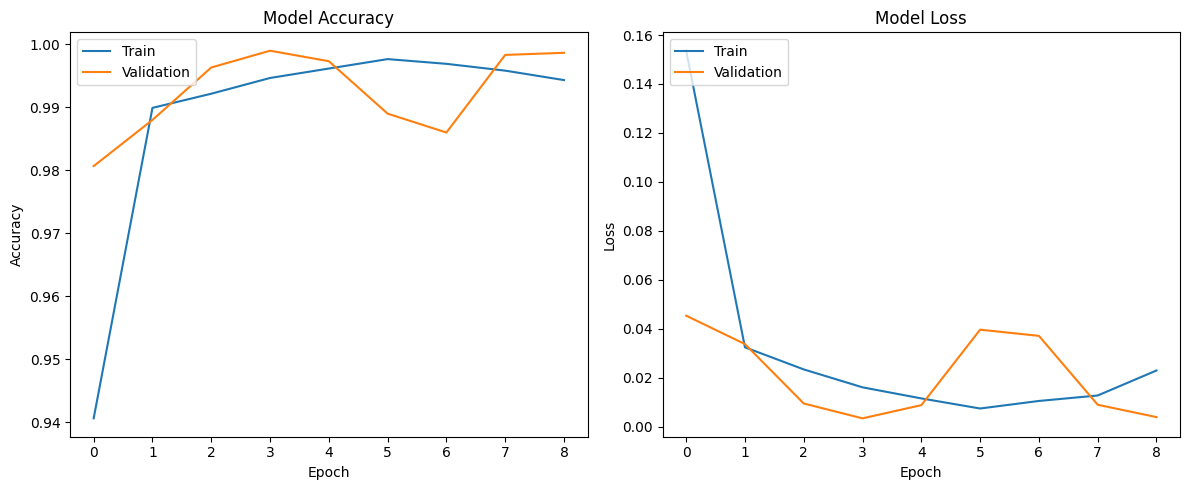

Evaluating the model on the validation set...
94/94 [==============================] - 23s 247ms/step - loss: 0.0034 - accuracy: 0.9990
Validation Accuracy: 99.90%
Weighted F1 Score: 0.9990
Weighted Precision: 0.9990
Weighted Recall: 0.9990
Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       1.00      1.00      1.00      1000
                 benign       1.00      1.00      1.00      1000
squamous_cell_carcinoma       1.00      1.00      1.00      1000

               accuracy                           1.00      3000
              macro avg       1.00      1.00      1.00      3000
           weighted avg       1.00      1.00      1.00      3000



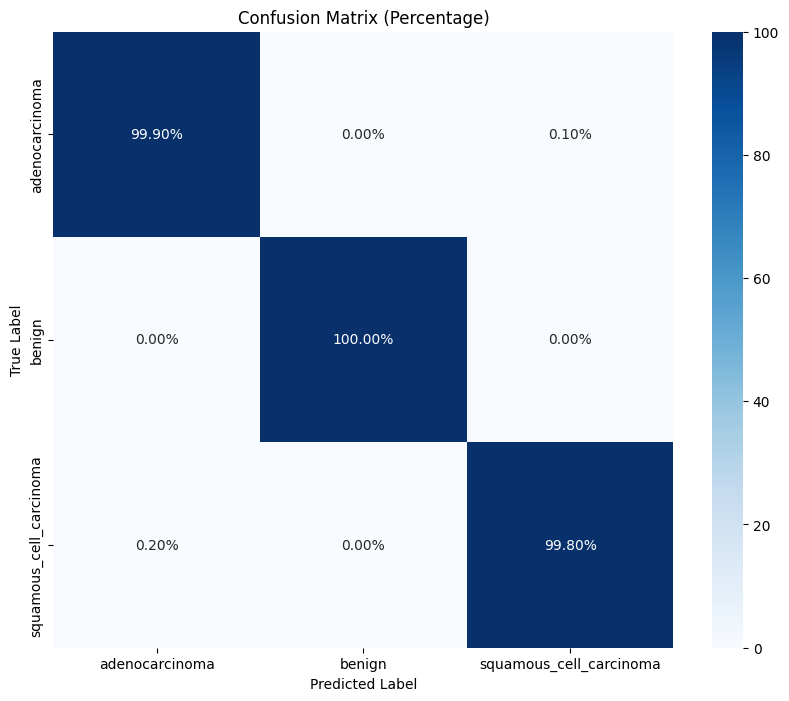

In [29]:
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Get the class labels
class_labels = list(train_class_indices.keys())

# Count the number of images per class in training and validation sets
train_counts = np.zeros(len(class_labels))
validation_counts = np.zeros(len(class_labels))

for i, label in enumerate(train_generator.classes):
    train_counts[label] += 1

for i, label in enumerate(validation_generator.classes):
    validation_counts[label] += 1

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

ax[1].bar(class_labels, validation_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

# Function to get image shapes
def get_image_shapes(generator):
    shapes = []
    for i in range(len(generator)):
        images, _ = generator[i]
        for img in images:
            shapes.append(img.shape)
    return np.array(shapes)

# Get shapes for training and validation sets
train_shapes = get_image_shapes(train_generator)
validation_shapes = get_image_shapes(validation_generator)

# Calculate statistics
def calculate_statistics(shapes):
    unique_shapes = np.unique(shapes, axis=0)
    min_dimensions = np.min(shapes, axis=0)
    max_dimensions = np.max(shapes, axis=0)
    mean_dimensions = np.mean(shapes, axis=0)
    return unique_shapes, min_dimensions, max_dimensions, mean_dimensions

train_unique_shapes, train_min_dimensions, train_max_dimensions, train_mean_dimensions = calculate_statistics(train_shapes)
validation_unique_shapes, validation_min_dimensions, validation_max_dimensions, validation_mean_dimensions = calculate_statistics(validation_shapes)

# Print statistics
print("Training Dataset:")
print(f"Number of images: {len(train_shapes)}")
print(f"Unique shapes: {train_unique_shapes}")
print(f"Min dimensions: {train_min_dimensions}")
print(f"Max dimensions: {train_max_dimensions}")
print(f"Mean dimensions: {train_mean_dimensions}")

print("\nValidation Dataset:")
print(f"Number of images: {len(validation_shapes)}")
print(f"Unique shapes: {validation_unique_shapes}")
print(f"Min dimensions: {validation_min_dimensions}")
print(f"Max dimensions: {validation_max_dimensions}")
print(f"Mean dimensions: {validation_mean_dimensions}")


# Load the DenseNet121 model, excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.summary()



# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)


# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)



# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, check_point]
)


# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


MODEL_NAME = "lung_cancer-densenet121"
OUTPUT_CONFUSION_MATRICES_DIR = os.path.join('../output/confusion_matrices/', MODEL_NAME)
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
OUTPUT_EVALUATION_METRICS_DIR = os.path.join('../output/evaluation_metrics/', MODEL_NAME)
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)


# Evaluate the model on the validation data
print("Evaluating the model on the validation set...")
validation_generator.reset()  # Reset the generator to ensure predictions are correct
Y_pred_prob = model.predict(validation_generator, verbose=1)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Calculate metrics
evaluation_accuracy = model.evaluate(validation_generator, verbose=1)[1]
f1 = f1_score(Y_true, Y_pred, average='weighted')
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Confusion matrix with percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percentage = np.nan_to_num(cm_percentage)

# Prepare annotations with percentage symbol
annot_labels = np.empty_like(cm_percentage).astype(str)
nrows, ncols = cm_percentage.shape
for i in range(nrows):
    for j in range(ncols):
        annot_labels[i, j] = f'{cm_percentage[i, j]:.2f}%'

plt.figure(figsize=(10,8))
sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Save confusion matrix
OUTPUT_CONFUSION_MATRICES_DIR = '../output/confusion_matrices/' + MODEL_NAME
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'confusion_matrix_percentage.png')
plt.savefig(confusion_matrix_path)
plt.show()

# Save evaluation metrics to CSV
import pandas as pd
metrics_data = {
    'Metric': ['Validation Accuracy', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall'],
    'Value': [evaluation_accuracy, f1, precision, recall]
}
metrics_df = pd.DataFrame(metrics_data)
OUTPUT_EVALUATION_METRICS_DIR = '../output/evaluation_metrics/' + MODEL_NAME
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)
metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)

# Save the final model
MODEL_DIR = '../models/' + MODEL_NAME
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, 'model_final.h5'))

In [46]:
# Common settings
base_dir = '../Data/raw/5'
img_height, img_width = 150, 150
batch_size = 32

def random_contrast(image):
    contrast_factor = tf.random.uniform([], 0.5, 1.5)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,  # Increased to 0.2 for a clearer split
    preprocessing_function=random_contrast
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use the same split as train_datagen
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Specify 'validation' subset
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


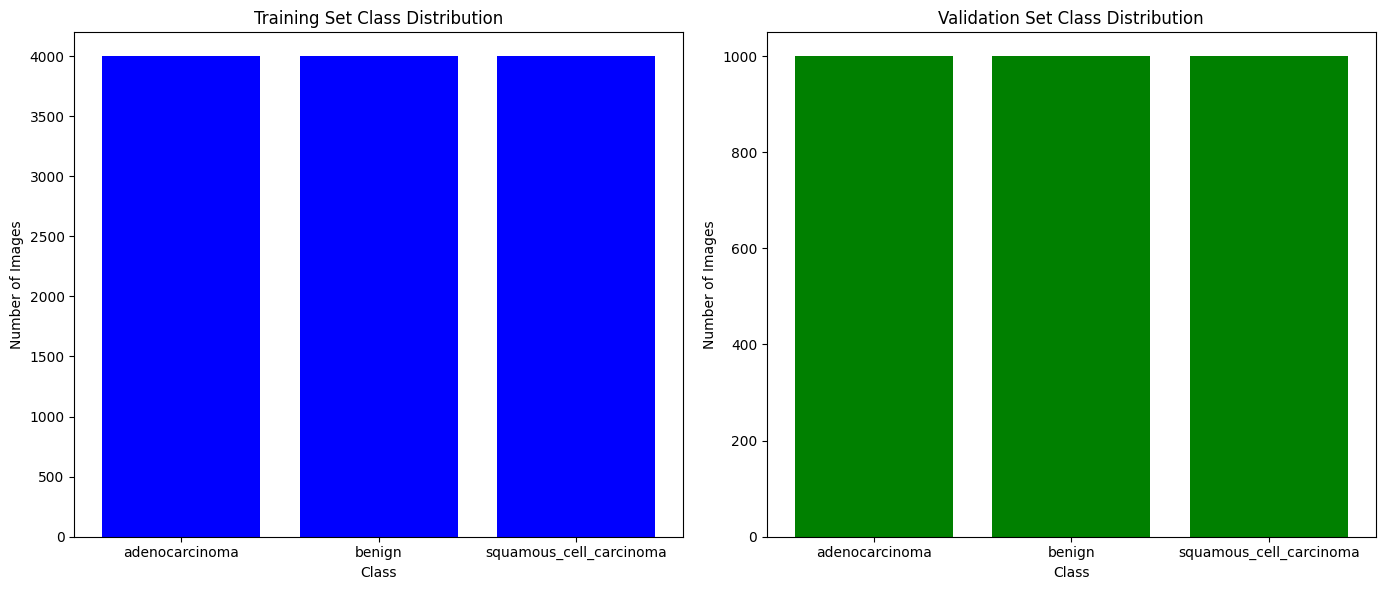

Training Dataset:
Number of images: 12000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]

Validation Dataset:
Number of images: 3000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 156, 156, 3)  0          ['input_10[0][0]']               
 D)                                                  

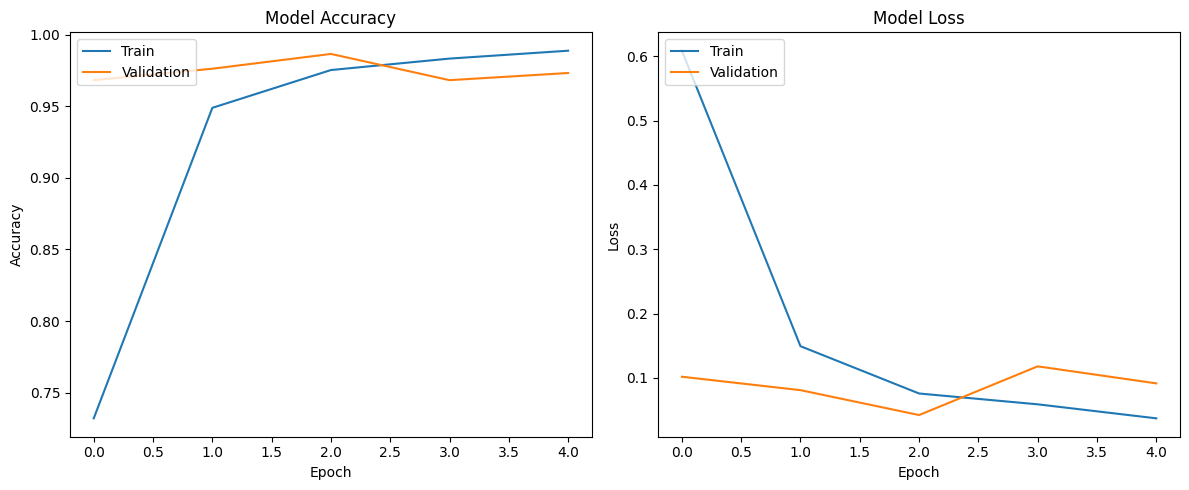

Evaluating the model on the validation set...
94/94 [==============================] - 22s 235ms/step - loss: 0.0420 - accuracy: 0.9867
Validation Accuracy: 98.67%
Weighted F1 Score: 0.9867
Weighted Precision: 0.9870
Weighted Recall: 0.9867
Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       1.00      0.96      0.98      1000
                 benign       1.00      1.00      1.00      1000
squamous_cell_carcinoma       0.97      1.00      0.98      1000

               accuracy                           0.99      3000
              macro avg       0.99      0.99      0.99      3000
           weighted avg       0.99      0.99      0.99      3000



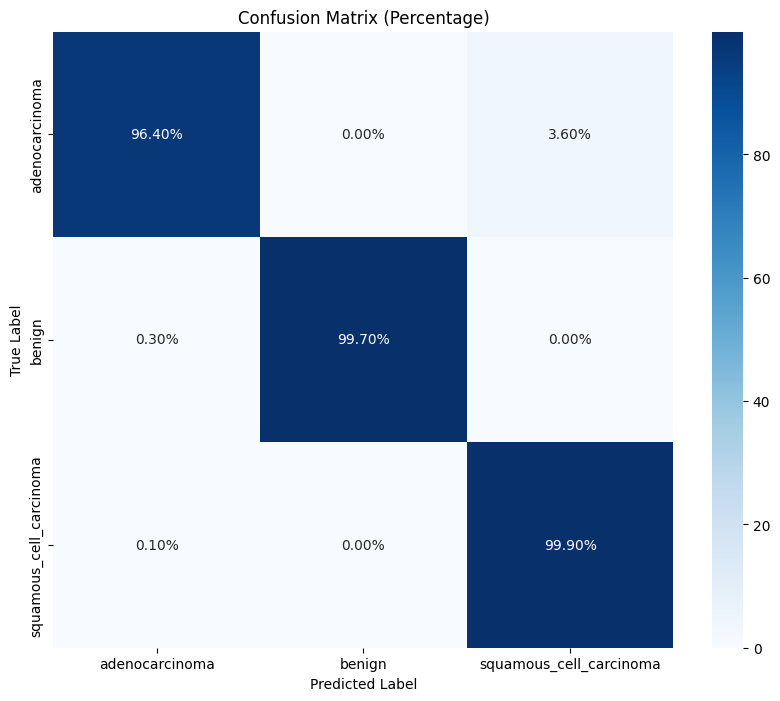

In [50]:
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Get the class labels
class_labels = list(train_class_indices.keys())

# Count the number of images per class in training and validation sets
train_counts = np.zeros(len(class_labels))
validation_counts = np.zeros(len(class_labels))

for i, label in enumerate(train_generator.classes):
    train_counts[label] += 1

for i, label in enumerate(validation_generator.classes):
    validation_counts[label] += 1

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

ax[1].bar(class_labels, validation_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

# Function to get image shapes
def get_image_shapes(generator):
    shapes = []
    for i in range(len(generator)):
        images, _ = generator[i]
        for img in images:
            shapes.append(img.shape)
    return np.array(shapes)

# Get shapes for training and validation sets
train_shapes = get_image_shapes(train_generator)
validation_shapes = get_image_shapes(validation_generator)

# Calculate statistics
def calculate_statistics(shapes):
    unique_shapes = np.unique(shapes, axis=0)
    min_dimensions = np.min(shapes, axis=0)
    max_dimensions = np.max(shapes, axis=0)
    mean_dimensions = np.mean(shapes, axis=0)
    return unique_shapes, min_dimensions, max_dimensions, mean_dimensions

train_unique_shapes, train_min_dimensions, train_max_dimensions, train_mean_dimensions = calculate_statistics(train_shapes)
validation_unique_shapes, validation_min_dimensions, validation_max_dimensions, validation_mean_dimensions = calculate_statistics(validation_shapes)

# Print statistics
print("Training Dataset:")
print(f"Number of images: {len(train_shapes)}")
print(f"Unique shapes: {train_unique_shapes}")
print(f"Min dimensions: {train_min_dimensions}")
print(f"Max dimensions: {train_max_dimensions}")
print(f"Mean dimensions: {train_mean_dimensions}")

print("\nValidation Dataset:")
print(f"Number of images: {len(validation_shapes)}")
print(f"Unique shapes: {validation_unique_shapes}")
print(f"Min dimensions: {validation_min_dimensions}")
print(f"Max dimensions: {validation_max_dimensions}")
print(f"Mean dimensions: {validation_mean_dimensions}")


# Load the DenseNet121 model, excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.summary()



# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)


# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
check_point = ModelCheckpoint('../models_reduce_lr/best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min',min_lr=1e-6)



# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, check_point, reduce_lr]
)


# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


MODEL_NAME = "lung_cancer-densenet121-augmented-reduce_lr"
OUTPUT_CONFUSION_MATRICES_DIR = os.path.join('../output/confusion_matrices/', MODEL_NAME)
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
OUTPUT_EVALUATION_METRICS_DIR = os.path.join('../output/evaluation_metrics/', MODEL_NAME)
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)


# Evaluate the model on the validation data
print("Evaluating the model on the validation set...")
validation_generator.reset()  # Reset the generator to ensure predictions are correct
Y_pred_prob = model.predict(validation_generator, verbose=1)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Calculate metrics
evaluation_accuracy = model.evaluate(validation_generator, verbose=1)[1]
f1 = f1_score(Y_true, Y_pred, average='weighted')
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Confusion matrix with percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percentage = np.nan_to_num(cm_percentage)

# Prepare annotations with percentage symbol
annot_labels = np.empty_like(cm_percentage).astype(str)
nrows, ncols = cm_percentage.shape
for i in range(nrows):
    for j in range(ncols):
        annot_labels[i, j] = f'{cm_percentage[i, j]:.2f}%'

plt.figure(figsize=(10,8))
sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Save confusion matrix
OUTPUT_CONFUSION_MATRICES_DIR = '../output/confusion_matrices/' + MODEL_NAME
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'confusion_matrix_percentage.png')
plt.savefig(confusion_matrix_path)
plt.show()

# Save evaluation metrics to CSV
import pandas as pd
metrics_data = {
    'Metric': ['Validation Accuracy', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall'],
    'Value': [evaluation_accuracy, f1, precision, recall]
}
metrics_df = pd.DataFrame(metrics_data)
OUTPUT_EVALUATION_METRICS_DIR = '../output/evaluation_metrics/' + MODEL_NAME
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)
metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)

# Save the final model
MODEL_DIR = '../models/' + MODEL_NAME
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, 'model_final.h5'))